<a href="https://www.kaggle.com/code/alnourabdalrahman9/stock-s-prices-analysis-forecast?scriptVersionId=182229566" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **INTRODUCTION**
This notebook delves into a comprehensive analysis on the stock prices of the top 6 companies within the S&P 500 index .

# Data Acquisition:

We'll leverage the yfinance library to download historical price data for the past year, allowing us to examine price movements and trends.

# Goal:

This analysis aims to provide a clear picture of the top 6 S&P 500 companies, including their price behavior, potential risks. The insights gained can be valuable for investment decision-making or simply understanding the current market landscape.

# Disclaimer:

This analysis is for informational purposes only and should not be considered financial advice. It's crucial to conduct your own research and due diligence before making any investment decisions.

# Here are some Questions to Guide Our Analysis:

What are the historical price trends over the past year?

How do the returns of these companies compare with each other?

What is the potential risk (VaR) associated with investing in each of these companies?

Which of these companies exhibit higher volatility and potential for greater returns or losses?

How can investors use historical data to inform their investment decisions for these companies?

In [1]:
# Install yfinance library
!pip install -q yfinance

# **Importing Libraries**

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import Callback, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime

import warnings

warnings.filterwarnings("ignore")  # Ignores all warnings


2024-06-08 13:58:29.566092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 13:58:29.566217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 13:58:29.708720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


# Downloading Historical Stock Prices:
This code block defines a list named top_6_companies containing the symbols for the top 6 companies in the S&P 500 . It then retrieves historical price data for each company using the yf.download function from Yahoo Finance.

In [3]:
# Define a list of the top 6 S&P 500 companies
top_6_companies = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA", "META"]

end = datetime(2024, 6, 5)
start = datetime(end.year - 1, end.month, end.day)

for stock in top_6_companies:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
company_list = [AAPL, GOOGL, MSFT, AMZN,META,NVDA]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON",'META',"NVIDIA"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-05-21,935.989990,954.000000,931.799988,953.859985,953.859985,32894600,NVIDIA
2024-05-22,954.590027,960.200012,932.489990,949.500000,949.500000,54864800,NVIDIA
2024-05-23,1020.280029,1063.199951,1015.200012,1037.989990,1037.989990,83506500,NVIDIA
2024-05-24,1044.489990,1064.750000,1030.000000,1064.689941,1064.689941,42650200,NVIDIA
2024-05-28,1102.439941,1149.390015,1098.829956,1139.010010,1139.010010,65272800,NVIDIA
2024-05-29,1130.500000,1154.920044,1109.010010,1148.250000,1148.250000,55744200,NVIDIA
2024-05-30,1146.500000,1158.189941,1096.630005,1105.000000,1105.000000,48735000,NVIDIA
2024-05-31,1125.199951,1127.170044,1069.400024,1096.329956,1096.329956,61326300,NVIDIA
2024-06-03,1136.209961,1150.000000,1120.030029,1150.000000,1150.000000,43839200,NVIDIA



# Visualizing Historical Closing Prices:

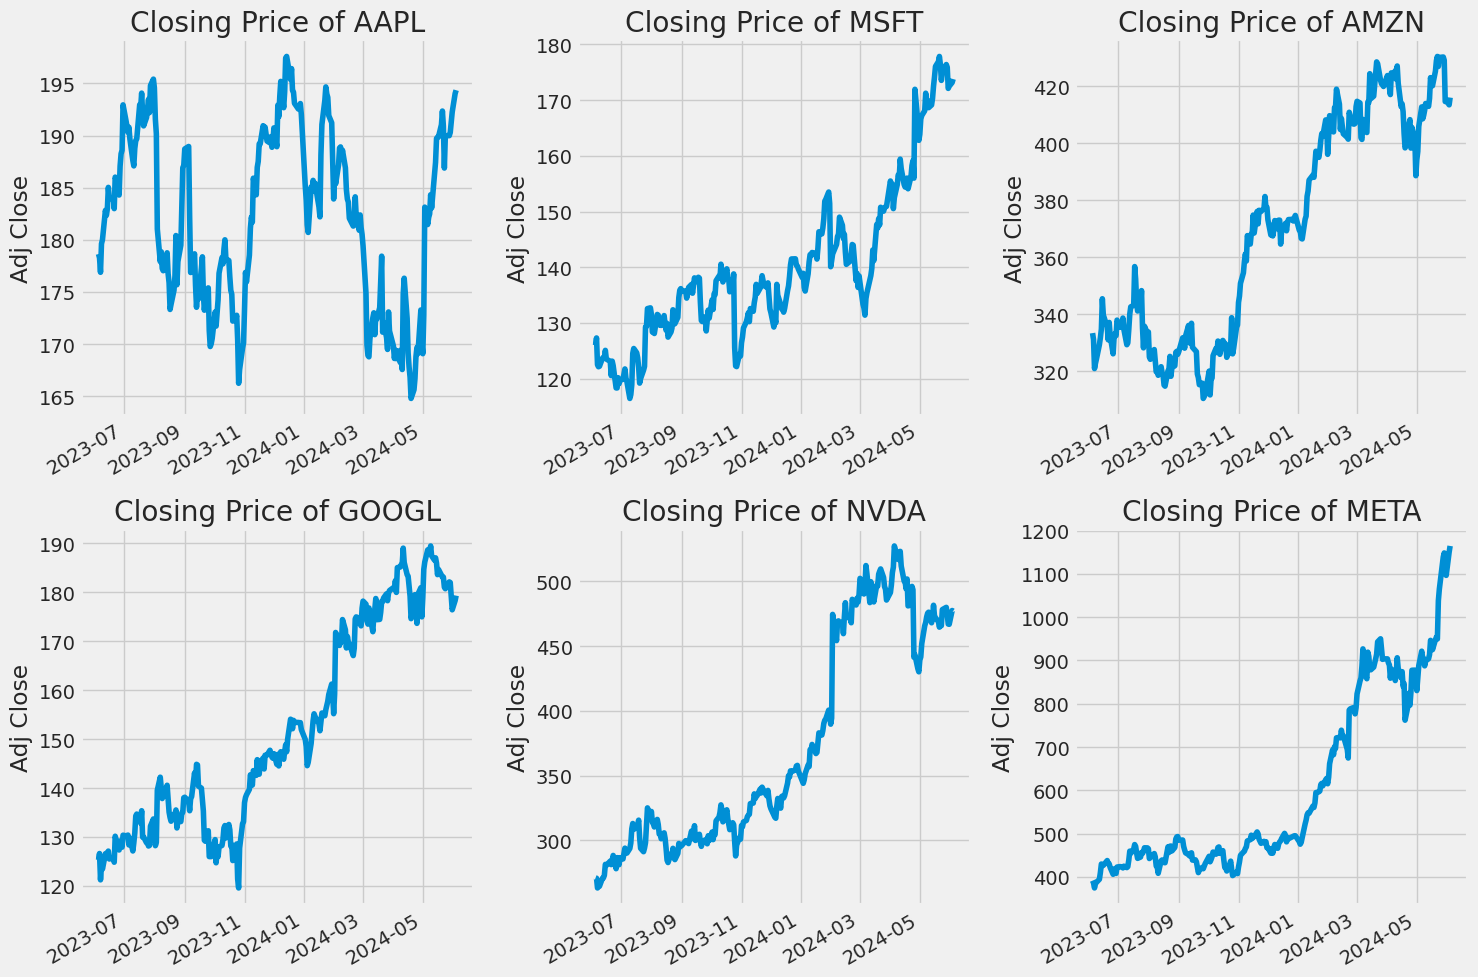

In [5]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 3, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {top_6_companies[i - 1]}")

plt.tight_layout()

# Visualizing Stock Prices with Exponential Moving Averages (EMA):

This code analyzes the top 6 S&P 500 companies by calculating and visualizing Exponential Moving Averages (EMAs) alongside their adjusted closing prices.

**What are EMAs?**

EMAs are a technical analysis tool used to identify trends and smooth out price fluctuations in a stock's price history. Unlike a simple moving average (SMA) that equally weights all past prices, EMAs give greater importance to more recent prices. This makes them more responsive to current market conditions.

**How are EMAs Used Here?**

The code calculates EMAs for three different timeframes (20, 50, and 200 days) for each company. These EMAs are plotted on the same chart as the adjusted closing prices, providing visual insights:

* Trend Identification: The direction of the EMA lines (upward, downward, or
flat) can suggest potential trends in the stock's price.
* Support and Resistance: EMAs can act as dynamic support and resistance levels. The price might find temporary support or encounter resistance as it approaches the EMA lines.

**Important Note:**

EMAs are lagging indicators, meaning they react to past price movements. They should not be used in isolation to predict future prices.

A comprehensive analysis should combine EMAs with other technical indicators and fundamental factors for better decision-making.

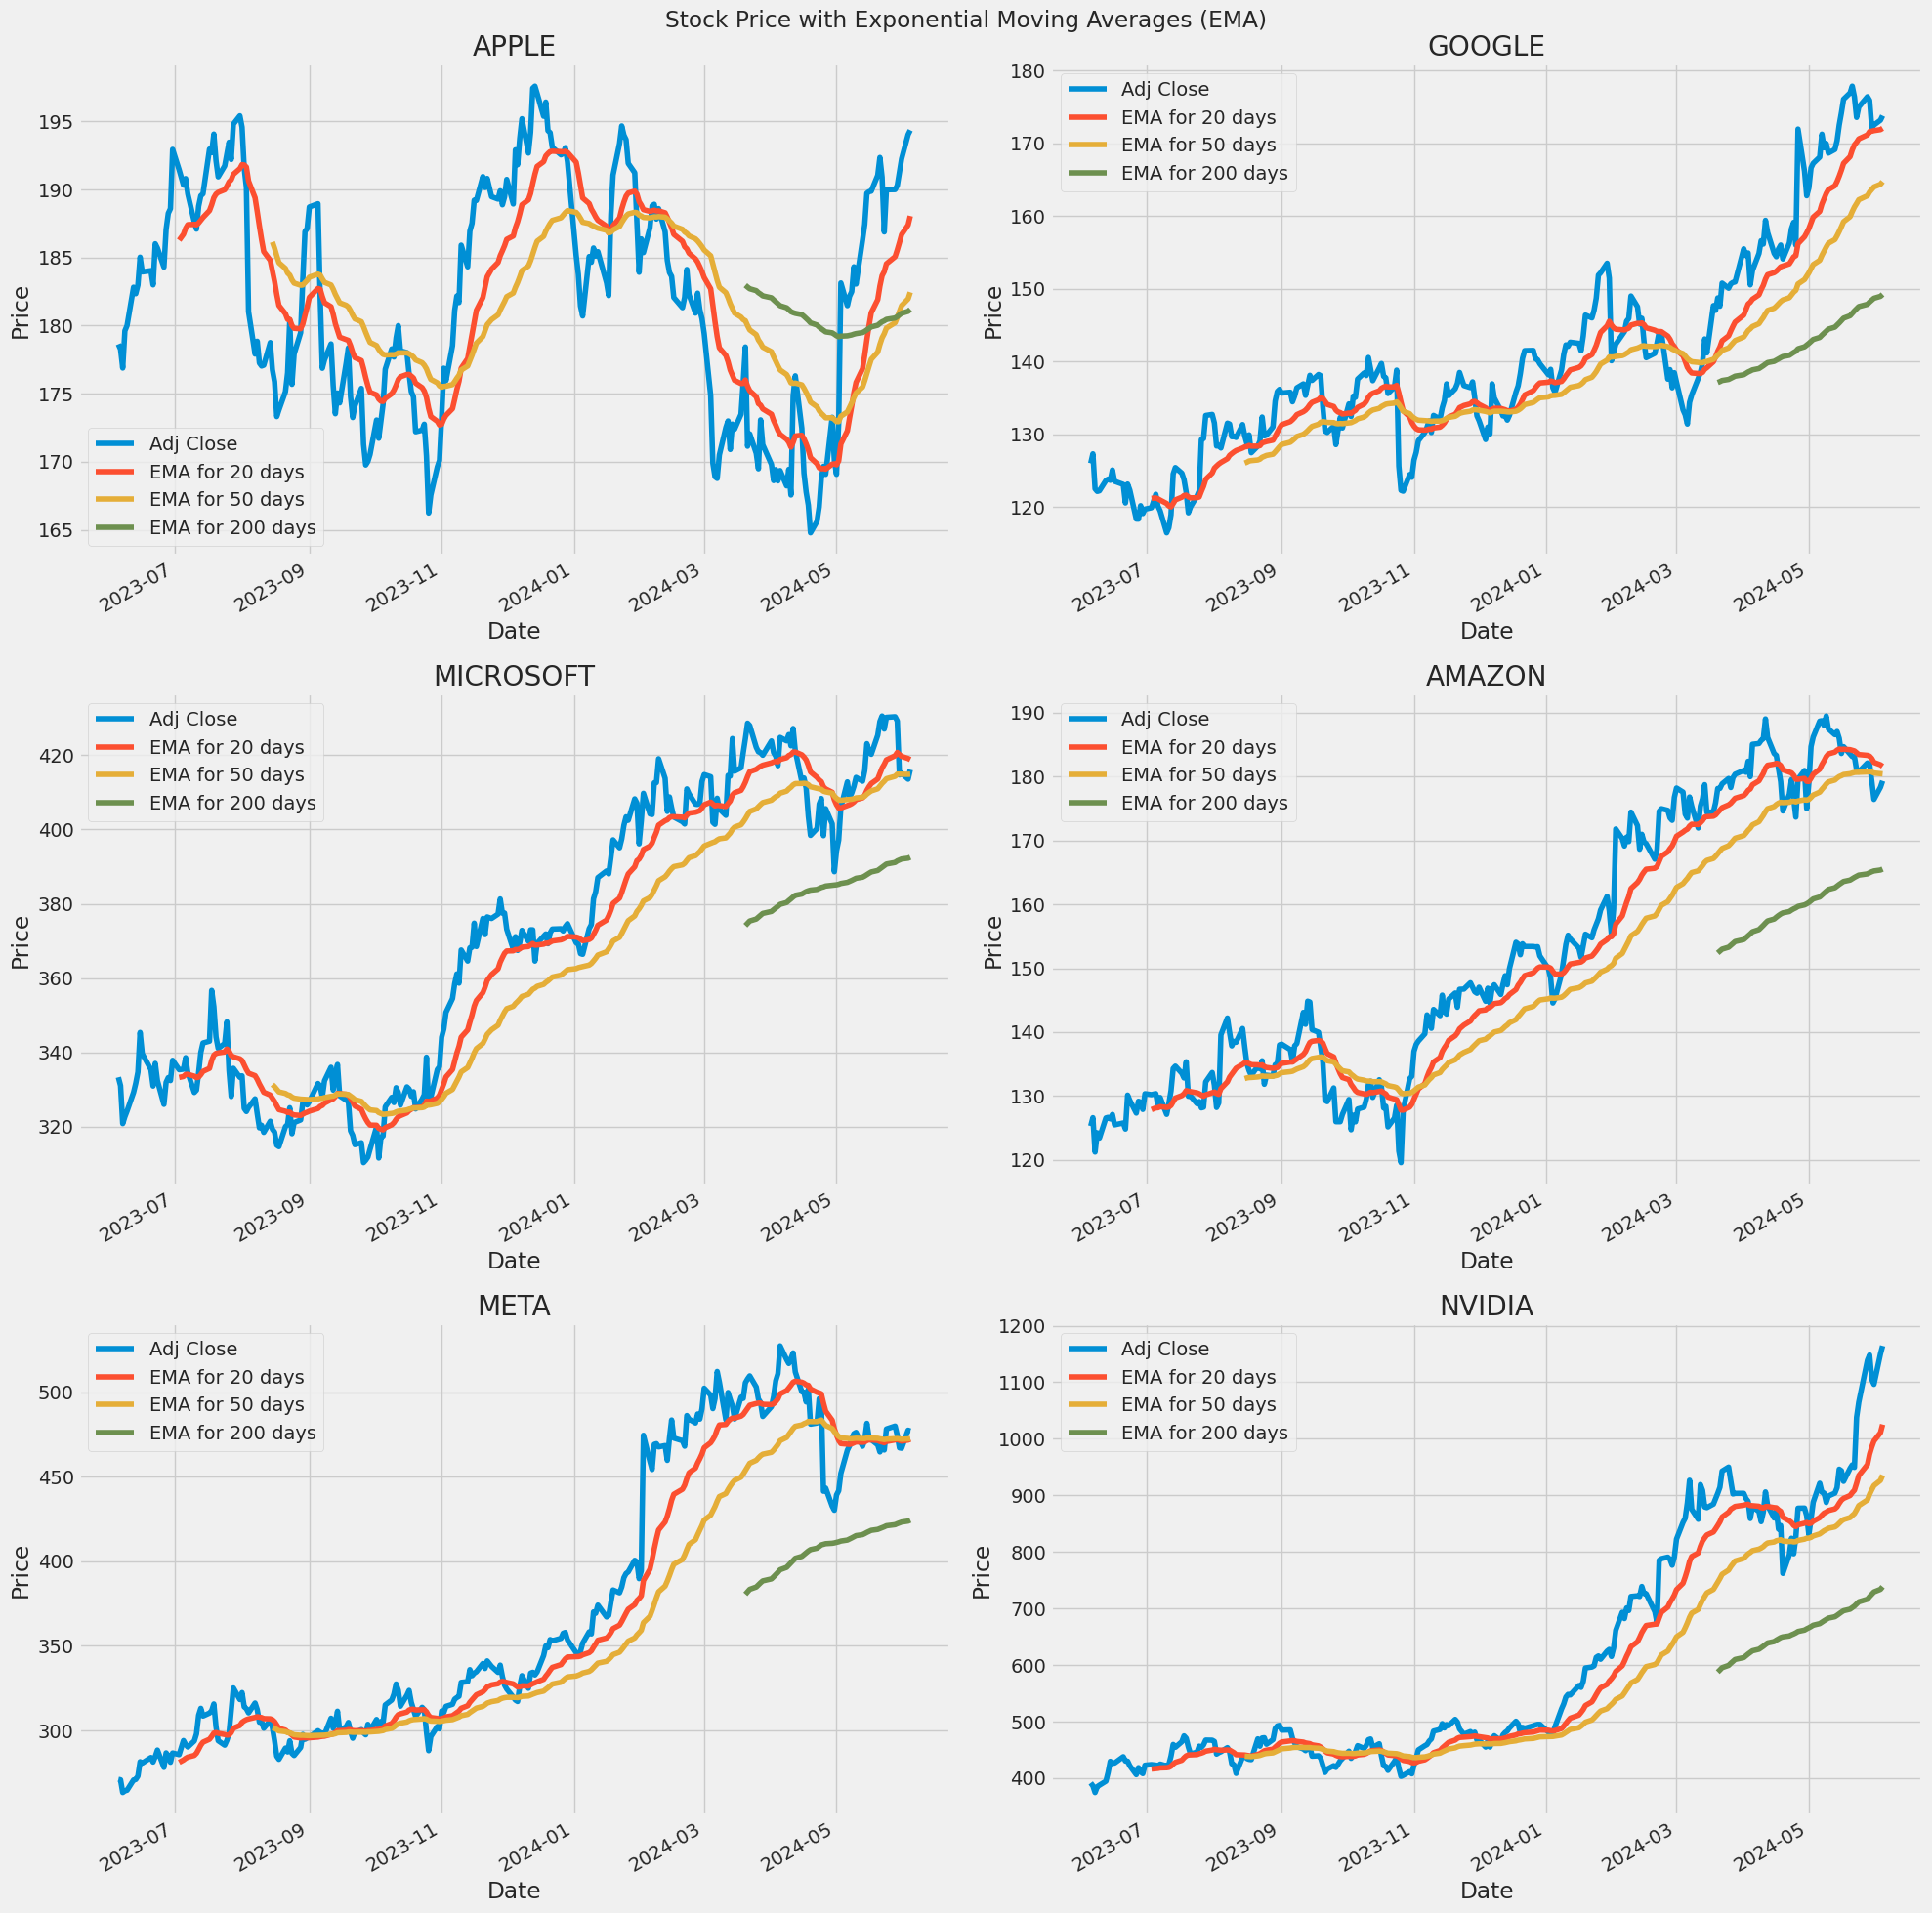

In [6]:
# Assuming 'company_list' stores your stock symbols and each stock has a DataFrame

ema_window = [20, 50, 200]  # List for EMA window lengths

for company in company_list:
  # Calculate Exponential Moving Averages (EMA)
  for window in ema_window:
    column_name = f"EMA for {window} days"
    company[column_name] = company['Adj Close'].ewm(span=window, min_periods=window).mean()

fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

# Plot for each company with adjusted Close and EMA lines
for i, company in enumerate(company_list):
  data = company[['Adj Close'] + [f"EMA for {w} days" for w in ema_window]]
  data.plot(ax=axes.flat[i])  # Use axes.flat to iterate over all subplots efficiently
  axes.flat[i].set_title(company['company_name'][0])  # Assuming company_name is the first element

# Add labels and adjust layout
fig.suptitle('Stock Price with Exponential Moving Averages (EMA)')
for ax in axes.flat:
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  ax.legend()  # Show legend for EMA lines
fig.tight_layout()

plt.show()


# Overall Insights from EMA Analysis:
Market Trend:

The fact that all companies are currently above their 200-day EMA suggests a potentially bullish (upward) trend in the overall market. This indicates a positive outlook for the stocks in the long term.

**Company-Specific Observations:**

- Apple (AAPL):Recent Breakout: The recent rise of Apple's 20-day and 50-day EMAs above the 200-day EMA suggests a bullish breakout signal. This indicates a potential shift in momentum towards the upside for Apple's stock price in the short and medium term.



- Google (GOOGL): Google's stock tested the 20-day EMA and and found a support on it ,This could suggest a continuation of the current trend.

- Amazon (AMZN): Amazon's price recently broke below both the 20-day and 50-day EMAs. This is generally considered a bearish signal, suggesting a potential short-term to medium-term downtrend. The strength of this signal depends on the severity of the break and previous price movement.
- Microsoft (MSFT): Microsoft's stock price is currently testing the 50-day EMA. This could be a sign of:
Consolidation: The price might find support and resume the previous uptrend.
Trend Reversal: If the price breaks below the 50-day EMA with significant volume, it could signal a potential medium-term downtrend.
- Meta (META): Meta's price has found support on the flattened 20-day and 50-day EMAs and now in a consolidation phase. A break below these levels accompanied by high volume could indicate a potential trend reversal..
- NVIDIA (NVDA):The current price being above all three Exponential Moving Averages (EMAs) - the 200-day (long-term), 50-day (medium-term), and 20-day (short-term) - is a bullish sign. This indicates the current price is higher than the average price across these respective timeframes, signifying a strong uptrend.

# Average Daily Return:

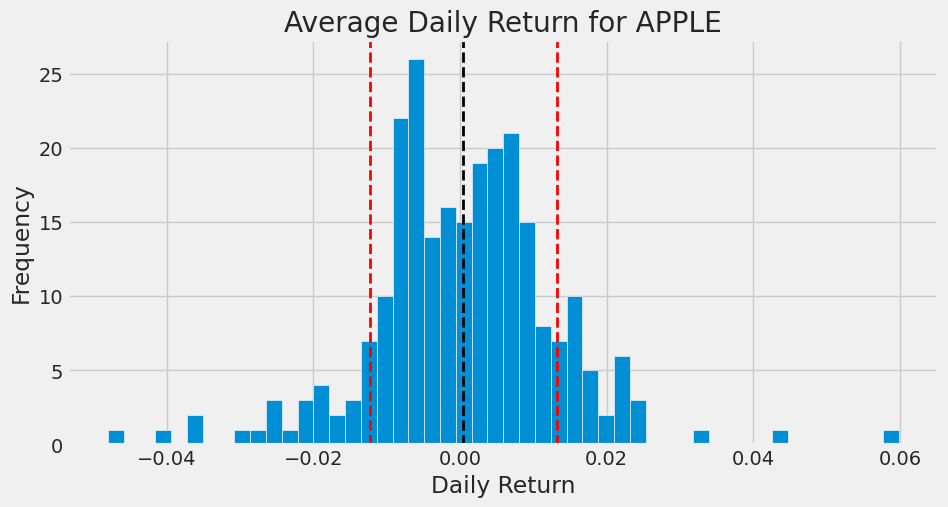

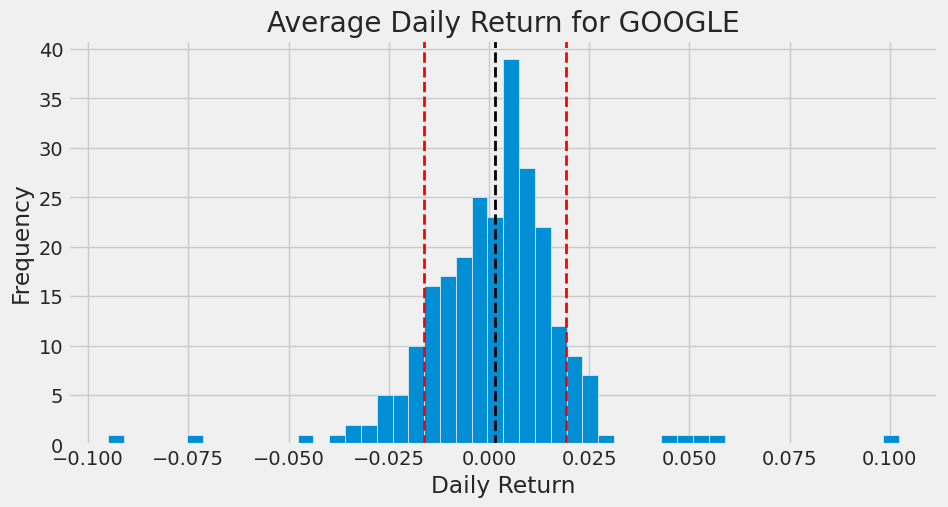

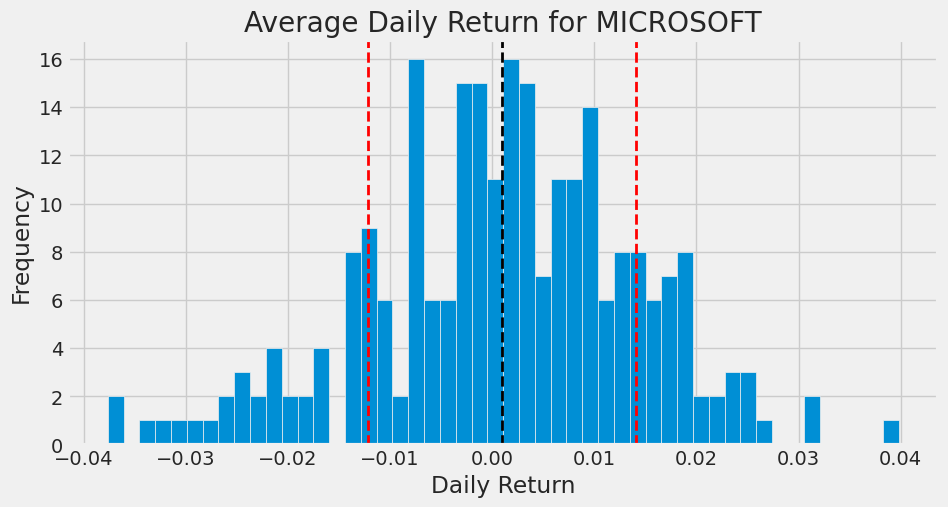

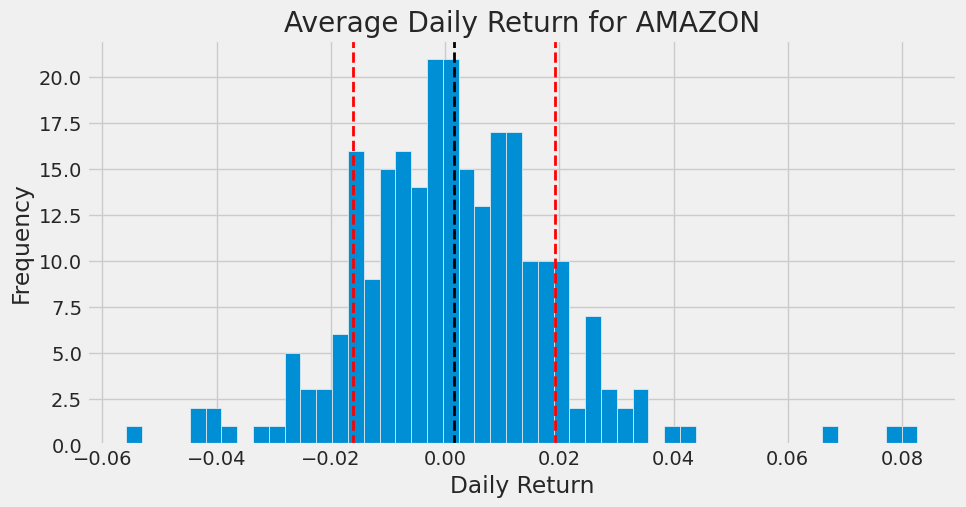

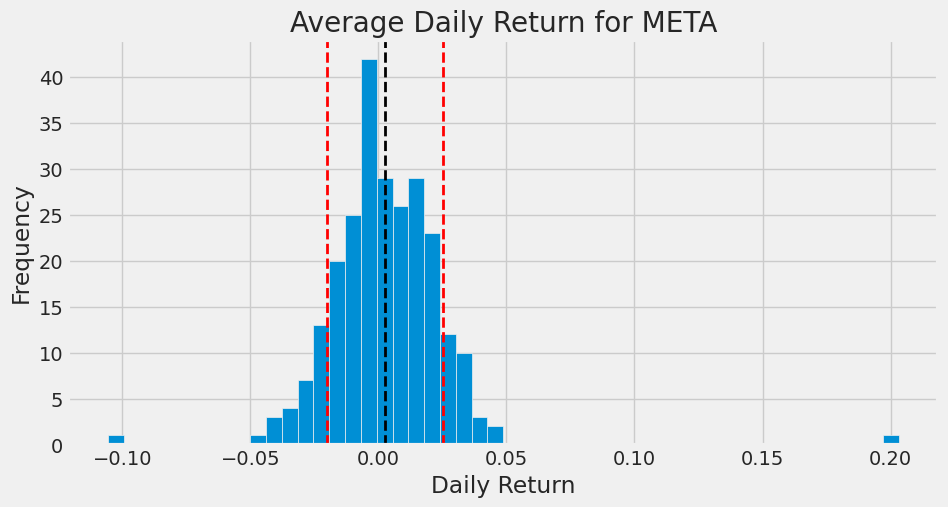

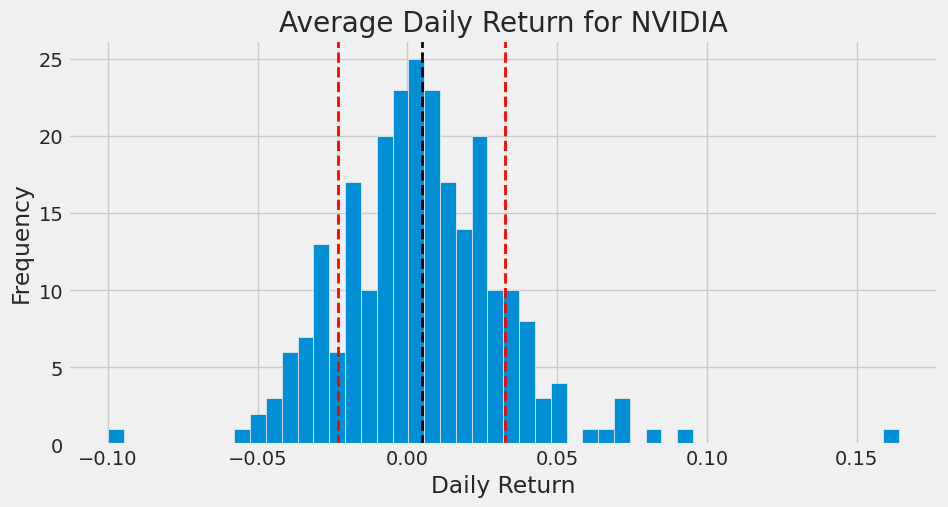

In [7]:
for stock in company_list:
  stock['Daily_Return'] = stock['Adj Close'].pct_change()
  avg_daily_return = stock['Daily_Return'].mean()
  std_daily_return = stock['Daily_Return'].std()
  plt.figure(figsize=(10, 5))
  plt.hist(stock['Daily_Return'], bins=50)
  plt.title(f"Average Daily Return for {stock['company_name'][0]}")
  plt.xlabel("Daily Return")
  plt.ylabel("Frequency")
  plt.axvline(avg_daily_return, color='k', linestyle='dashed', linewidth=2)
  plt.axvline(avg_daily_return + std_daily_return, color='r', linestyle='dashed', linewidth=2)
  plt.axvline(avg_daily_return - std_daily_return, color='r', linestyle='dashed', linewidth=2)
  plt.show()


# Volatility Analysis:

Utilizing the standard deviation of daily returns for the year provides a snapshot of historical volatility for each stock.
It reflects the dispersion of daily returns around the mean return over the entire year.

While it provides a measure of overall volatility, it doesn't offer insights into short-term fluctuations or changes in volatility patterns.

Despite not capturing temporal changes, it's useful for comparative analysis between different stocks or assets within the same timeframe.

**Using Rolling Standard Deviation:**

Capturing Temporal Changes:

Rolling standard deviation calculates the volatility of daily returns over a rolling window of a specified length.
It captures changes in volatility over time, providing insights into short-term fluctuations.

Smoothed Volatility Measure:

The rolling standard deviation offers a smoothed volatility measure by incorporating recent data points while discarding older observations.
Identifying Volatility Trends:

This method facilitates the identification of volatility trends and patterns, aiding in risk management and trading strategies.

Trade-off with Window Length:

The choice of the rolling window length impacts the sensitivity of the measure.
Shorter windows provide more responsiveness to recent changes, whereas longer windows offer a broader perspective but may overlook short-term fluctuations.

In [8]:
for stock in company_list:
    # Calculate standard deviation of daily returns
    stock_volatility = stock["Daily_Return"].std()
    print(f"{stock['company_name'][0]} Volatility: {stock_volatility:.4f}")

APPLE Volatility: 0.0127
GOOGLE Volatility: 0.0177
MICROSOFT Volatility: 0.0131
AMAZON Volatility: 0.0177
META Volatility: 0.0227
NVIDIA Volatility: 0.0279


A lower standard deviation value (like Apple's 0.0127) indicates that the daily returns for that stock were more clustered around the average daily return. In simpler terms, the stock price experienced smaller daily fluctuations compared to the other companies over the analyzed period.
Conversely, a higher standard deviation value (like Meta's 0.0227 or Nvidia's 0.0279) suggests that the daily returns for that stock were more spread out from the average. This translates to larger daily price swings (both up and down) compared to the other companies during the analysis period.

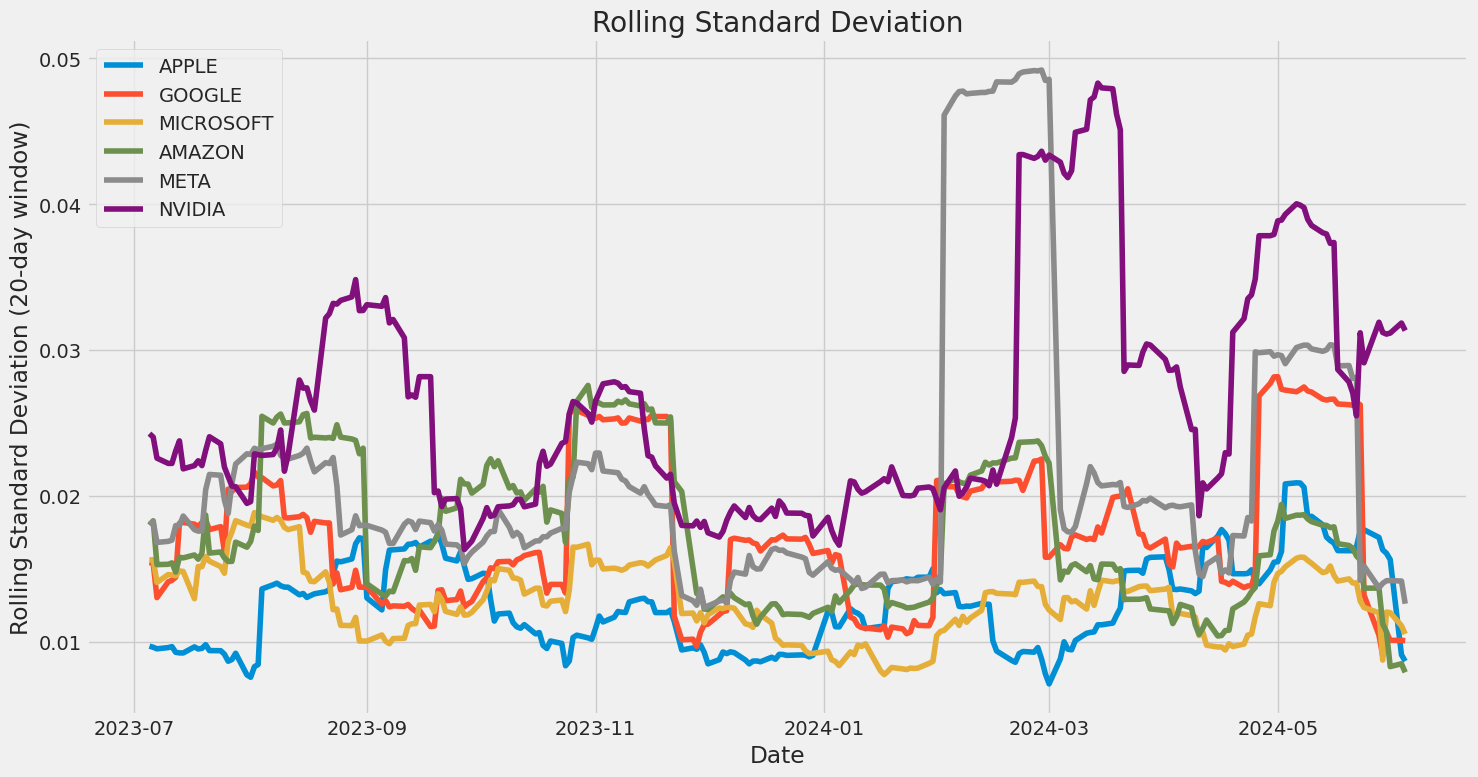

In [9]:
# Assuming 'company_list' stores your stock symbols and each stock has a DataFrame

plt.figure(figsize=(15, 8))  # Adjust figure size as needed

for stock in company_list:
  # Calculate Daily Return (if not already done)
  stock['Daily_Return'] = stock['Adj Close'].pct_change()

  # Calculate Rolling Standard Deviation (e.g., 20-day window)
  stock['Rolling_Std'] = stock['Daily_Return'].rolling(window=20).std()

  # Plot Rolling Std with label for legend
  plt.plot(stock['Daily_Return'].index, stock['Rolling_Std'], label=stock['company_name'][0])

# Add Labels and Title
plt.xlabel('Date')
plt.ylabel('Rolling Standard Deviation (20-day window)')
plt.title('Rolling Standard Deviation')

# Legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Insights from Volatility Analysis:

### Visual Interpretation of Rolling Standard Deviation Plot:
 Stocks exhibiting taller peaks or more frequent spikes in the rolling standard deviation plot are considered more volatile.
 Consistent high volatility over extended periods may suggest inherent riskiness, while fluctuations in volatility could indicate changing market conditions or company-specific events.
   - In the provided plot, NVIDIA and Meta (formerly Facebook) display the highest volatility, characterized by prominent peaks in the rolling standard deviation curve.
   - Amazon and Google show moderate volatility compared to other stocks, as evidenced by the presence of peaks of intermediate height in the rolling standard deviation plot.
   - Microsoft and Apple demonstrate relatively lower volatility, indicated by fewer and smaller peaks in the rolling standard deviation curve.

**Relative Comparison among Stocks:**
   - Comparative analysis of volatility levels among different stocks allows investors to gauge risk exposure and make informed investment decisions.
   - NVIDIA and Meta's higher volatility may appeal to risk-tolerant investors seeking potential higher returns, while Microsoft and Apple's lower volatility may attract more risk-averse investors.


In [10]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(top_6_companies, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  6 of 6 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
Date,,,,,,
2023-06-05,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-06,-0.002060,0.010455,0.010317,-0.000995,-0.006727,-0.013198
2023-06-07,-0.007756,-0.042493,-0.037782,-0.027737,-0.030868,-0.030401
2023-06-08,0.015465,0.024911,-0.002939,0.003718,0.005814,0.027618
2023-06-09,0.002160,-0.006600,0.000737,0.001399,0.004704,0.006751


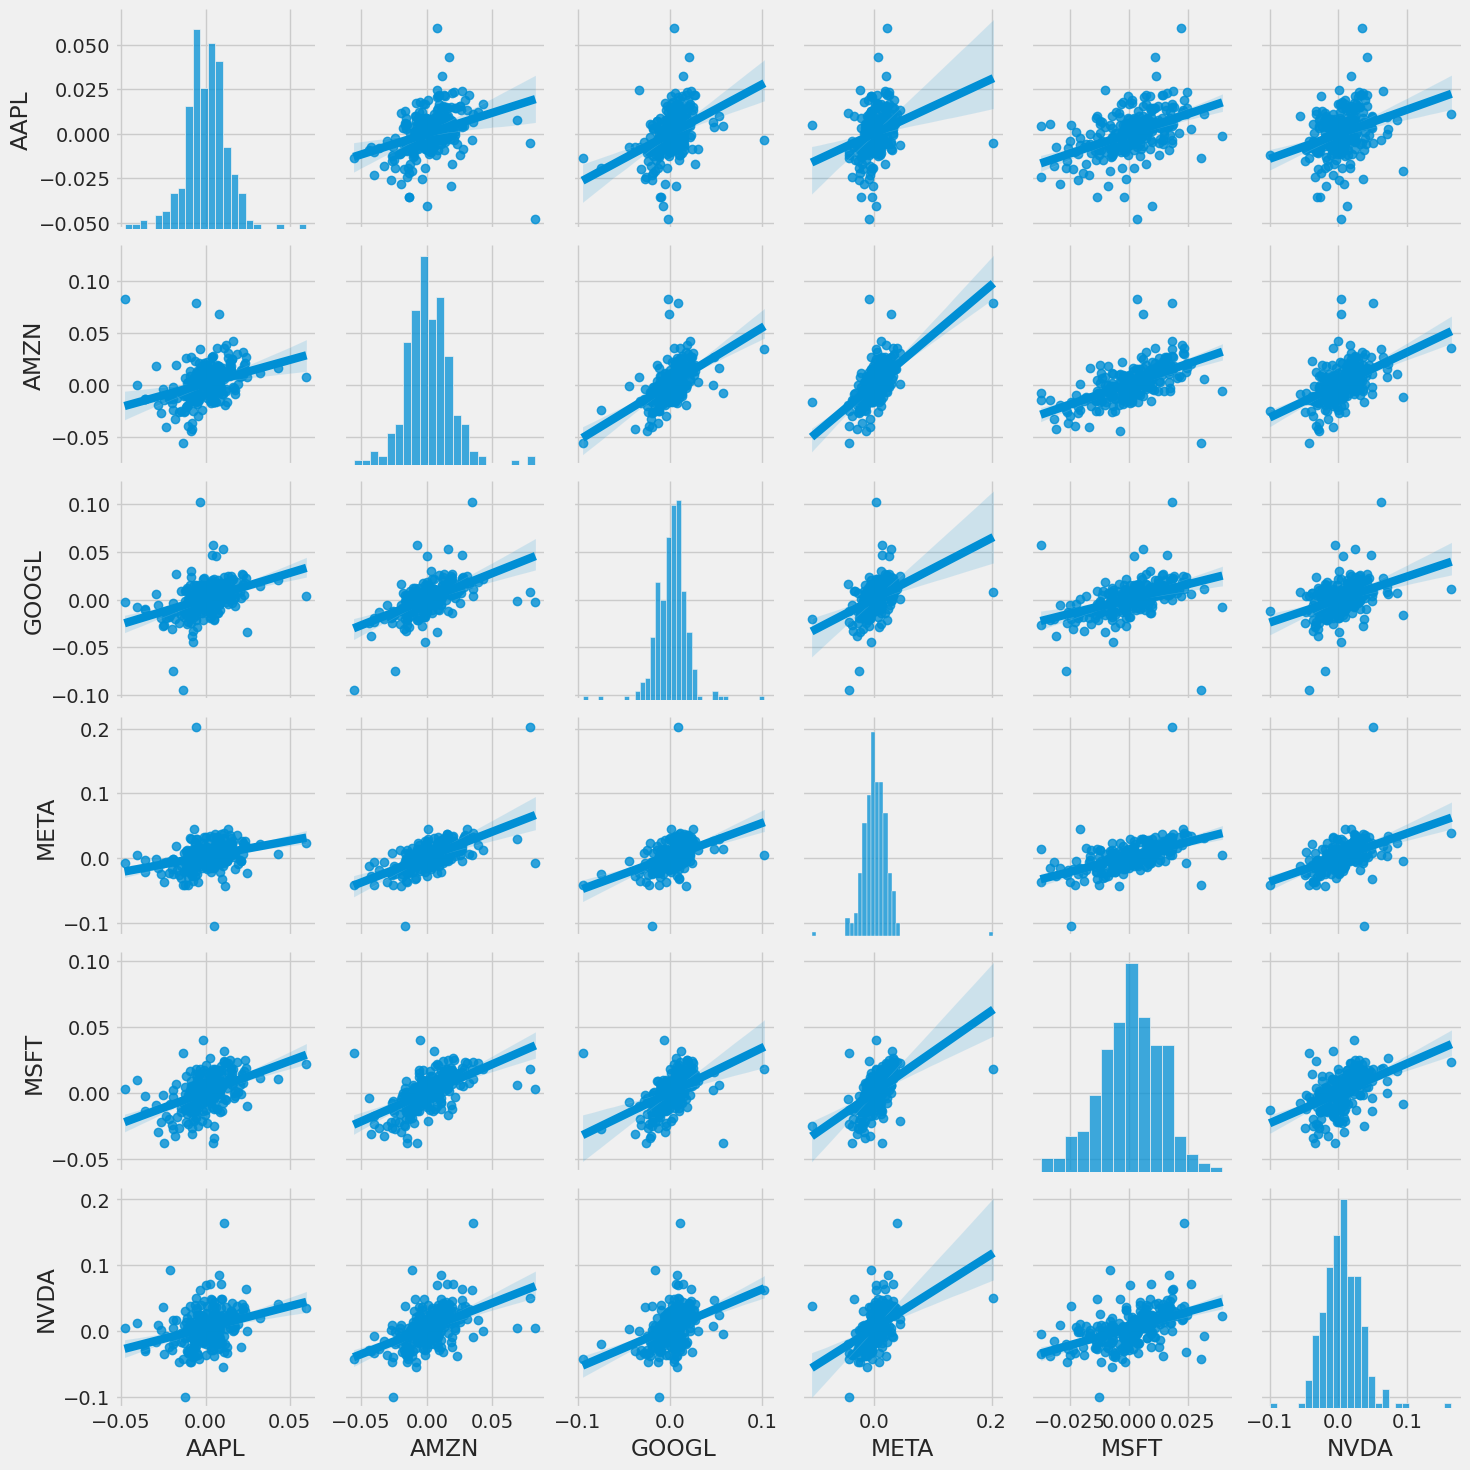

In [11]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis of all the comparisons

sns.pairplot(tech_rets, kind='reg')

Text(0.5, 1.0, 'Correlation of stock closing price')

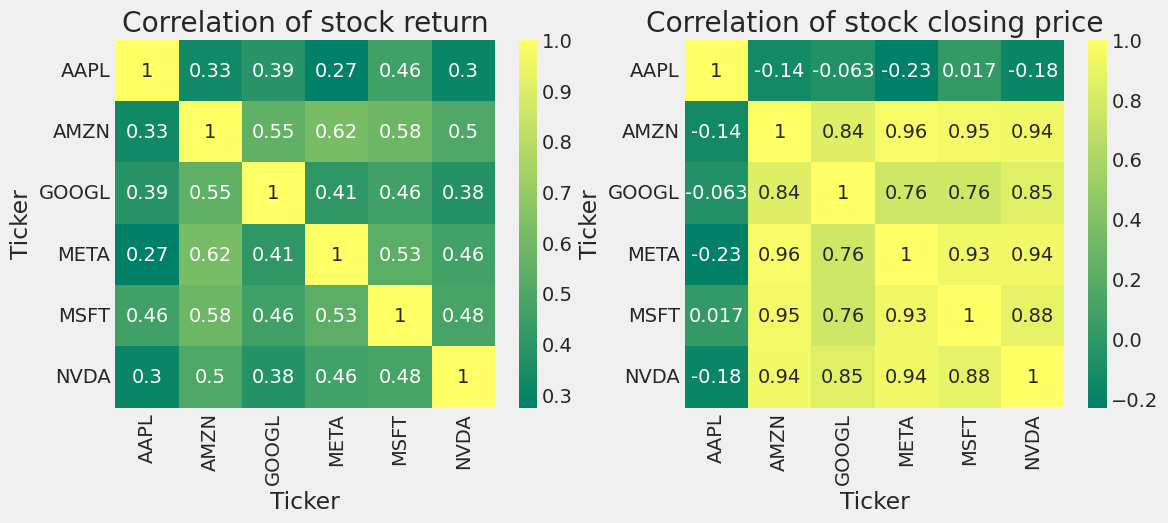

In [12]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

# General Observations:
Stock returns generally show moderate to strong positive correlations across the companies, with the highest correlation between AMAZON and META (0.62).
Stock closing prices show very high positive correlations among most companies, indicating that they tend to move in the same direction. The highest correlations are between AMAZON and META (0.96) and AMAZON and MICROSOFT (0.95).
APPLE is an exception with stock closing prices showing slight negative or very low positive correlations with other companies, suggesting that its price movements are more independent compared to the others.

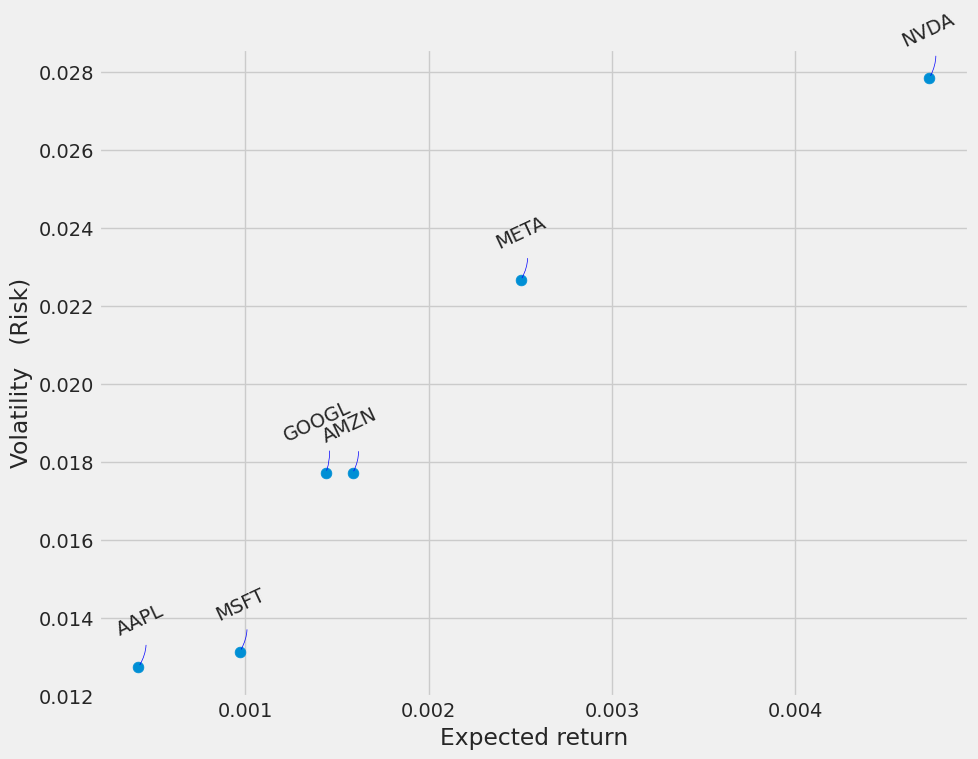

In [13]:
rets = tech_rets.dropna()

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=60)
plt.xlabel('Expected return')
plt.ylabel('Volatility   (Risk)')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
  plt.annotate(label, xy=(x, y), xytext=(20, 20), textcoords='offset points', ha='right', va='bottom',
              rotation=25,  # Add this line to rotate text by 45 degrees
              arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))


**Risk-Return Trade-off:**
The plot clearly illustrates the fundamental financial principle of risk-return trade-off. Stocks with higher volatility (risk) tend to offer higher expected returns.

**Value at Risk(VaR):**

In financial analysis, understanding the potential risk associated with investments is crucial for making informed decisions. Value at Risk (VaR) is a widely used metric that quantifies the maximum potential loss within a specified confidence level and time horizon.

In this analysis, we utilize VaR to assess the risk of daily returns for various stocks within the technology sector. By setting a confidence level of 95%, we aim to determine the maximum potential loss for each stock, providing valuable insights for risk management and portfolio optimization strategies.

In [14]:
# Set confidence level
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # Z-score for the given confidence level

# Iterate through each column (each stock)
for stock in tech_rets.columns:
    # Calculate standard deviation of daily returns
    stock_volatility = tech_rets[stock].std()

    # Calculate VaR for the given confidence level
    var = z_score * stock_volatility
    print(f"{stock} VaR ({confidence_level*100}% confidence): {var:.4f}")

AAPL VaR (95.0% confidence): 0.0250
AMZN VaR (95.0% confidence): 0.0347
GOOGL VaR (95.0% confidence): 0.0347
META VaR (95.0% confidence): 0.0444
MSFT VaR (95.0% confidence): 0.0258
NVDA VaR (95.0% confidence): 0.0546


# Key Insights:
The Value at Risk (VaR) insights provided below are based on a one-year period of analysis

AAPL (Apple Inc.):

VaR (95.0% confidence): 0.0250

Insight: There is a 5% chance that Apple's stock could lose 2.50% or more of its value over the specified period. Apple exhibits the lowest potential risk among the analyzed stocks, making it a relatively safer investment within this group.

AMZN (Amazon.com Inc.):

VaR (95.0% confidence): 0.0347

Insight: There is a 5% chance that Amazon's stock could lose 3.47% or more of its value. This indicates a moderate level of risk, higher than Apple but similar to Google's.

GOOGL (Alphabet Inc.):

VaR (95.0% confidence): 0.0347

Insight: There is a 5% chance that Alphabet's stock could lose 3.48% or more of its value. Alphabet's risk profile is similar to Amazon's, suggesting moderate potential losses.

META (Meta Platforms Inc.):

VaR (95.0% confidence): 0.0444

Insight: There is a 5% chance that Meta's stock could lose 4.44% or more of its value. Meta exhibits a higher risk compared to Apple, Amazon, and Alphabet, indicating larger potential losses.

MSFT (Microsoft Corp.):

VaR (95.0% confidence): 0.0258

Insight: There is a 5% chance that Microsoft's stock could lose 2.58% or more of its value. Microsoft has a low-risk profile similar to Apple's, making it another relatively safe investment option among the analyzed stocks.

NVDA (NVIDIA Corp.):

VaR (95.0% confidence): 0.0546

Insight: There is a 5% chance that NVIDIA's stock could lose 5.46% or more of its value. NVIDIA exhibits the highest potential risk, indicating significant potential losses. Investors in NVIDIA should be prepared for higher volatility.


# General Insights:
Investment Strategy: Depending on the investor's risk tolerance, different stocks may be preferred. Conservative investors may lean towards AAPL and MSFT for their stability, while aggressive investors may prefer NVDA for its high potential returns despite the high risk.

Diversification: Given the varying levels of risk and return, investors might consider diversifying their portfolio across these stocks to balance potential returns with acceptable risk levels.


# **Predicting the Closing Price for Apple (AAPL) Stock:**

Based on our comprehensive analysis on the top six companies of the S&P 500 index, we identified Apple (AAPL) as the least volatile stock. Given this characteristic, we will use AAPL as a case study to predict its closing price. Our approach will encompass several key steps:

**1/Understanding Stock Behavior Through Technical Indicators:**

We will start by calculating several technical indicators that are widely used by traders and analysts to understand stock behavior:

**Relative Strength Index (RSI):**
 Helps identify overbought or oversold conditions of the stock. By examining RSI, we aim to understand the momentum and potential reversal points of AAPL stock prices.

**Bollinger Bands:**
Provide insight into the volatility of the stock. The widening and narrowing of the bands will help us gauge periods of high and low volatility.

**Moving Average Convergence Divergence (MACD):** Used to identify changes in the strength, direction, momentum, and duration of a trend in the stock's price.

**2/Scaling the Data:**

We'll use MinMaxScaler to scale our features between 0 and 1, ensuring uniformity and preventing features with larger scales from dominating the model's learning process, thus improving convergence and enhancing the model's performance

**3/Predicting Stock Prices Using LSTM:**

The core of our analysis will focus on using a Long Short-Term Memory (LSTM) neural network to predict the closing prices of AAPL stock. We will aim to answer the following questions:

We're using  a Long Short-Term Memory (LSTM) neural network for its capability to capture sequential patterns and long-term dependencies within time-series data like AAPL stock prices. With LSTM, we can exploit historical data effectively to predict future closing prices.

Splitting our data into 70% for training and 30% for testing will allow us to train the LSTM model on a substantial portion of historical data while retaining a significant chunk for evaluating its performance. This division ensures robust training and provides a fair assessment of the model's predictive abilities.

**4/Evaluating Model Performance:**

We will calculate RMSE to quantitatively measure the model's performance. A lower RMSE value will indicate better predictive accuracy.

# **Data Downloading:**
For our analysis, we'll utilize data starting from January 1, 2012, up to the present day. We'll split this data into 70% for training purposes and 30% for validation.

In [15]:
# Get the stock data
AAPL = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show the data
AAPL

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.416982,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.483711,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.622306,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.754258,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.734027,394024400
...,...,...,...,...,...,...
2024-06-03,192.899994,194.990005,192.520004,194.029999,194.029999,50080500
2024-06-04,194.639999,195.320007,193.029999,194.350006,194.350006,47471400
2024-06-05,195.399994,196.899994,194.869995,195.869995,195.869995,54156800


In [16]:
# Calculate RSI (Relative Strength Index)
def calculate_RSI(data, window=14):
    delta = data['Close'].diff()
    delta = delta[1:]  # Ignore first delta (NaN)
    up, down = delta.clip(lower=0), delta.clip(upper=0) * -1
    ema_up = up.ewm(alpha=1/window, min_periods=window).mean()
    ema_down = down.ewm(alpha=1/window, min_periods=window).mean()
    RS = ema_up / ema_down
    RSI = 100 - (100 / (1 + RS))
    return RSI

AAPL['RSI'] = calculate_RSI(AAPL)

# Calculate Bollinger Bands (Upper and Lower bands)
def calculate_bollinger_bands(data, window=20):
    moving_average = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    bollinger_high = moving_average + (2 * std)
    bollinger_low = moving_average - (2 * std)
    return bollinger_high, bollinger_low

AAPL['Bollinger_High'], AAPL['Bollinger_Low'] = calculate_bollinger_bands(AAPL)

# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, slow_ema=26, fast_ema=12, signal_ema=9):
    ema_fast = data['Close'].ewm(span=fast_ema, min_periods=fast_ema).mean()
    ema_slow = data['Close'].ewm(span=slow_ema, min_periods=slow_ema).mean()
    MACD = ema_fast - ema_slow
    signal_line = MACD.ewm(span=signal_ema, min_periods=signal_ema).mean()
    return MACD, signal_line

AAPL['MACD'], AAPL['Signal_Line'] = calculate_macd(AAPL)

In [17]:
AAPL.dropna(inplace=True)

In [18]:
# Create a new dataframe
data = AAPL.filter(['Close', 'RSI','MACD', 'Bollinger_High', 'Bollinger_Low','Volume','Open','Signal_Line'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .70 ))

training_data_len

2167

**Early Stopping and Model Checkpointing:**

 These techniques will help prevent overfitting and ensure that we use the best model weights during prediction. Early stopping will monitor the validation loss and stop training when it ceases to improve, while model checkpointing will save the best model weights.

In [19]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])  # Use all columns for x_train
    y_train.append(train_data[i, 0])  # Predict the 'Close' price (first column)

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data to be accepted by the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, 0]  # Only the 'Close' column

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])  # Use all columns for x_test

# Convert the data to a numpy array
x_test = np.array(x_test)

class TestRMSECallback(Callback):
    def __init__(self, x_test, y_test, scaler, patience=5):
        super().__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = scaler
        self.best_rmse = float('inf')
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.x_test)
        predicted_prices = np.zeros((predictions.shape[0], self.scaler.scale_.shape[0]))
        predicted_prices[:, 0] = predictions[:, 0]
        predicted_prices = self.scaler.inverse_transform(predicted_prices)
        predictions = predicted_prices[:, 0]
        y_test = self.y_test[:len(predictions)]
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        print(f'Epoch {epoch + 1}: Test RMSE: {rmse:.4f}')

        # Implement early stopping based on test RMSE
        if rmse < self.best_rmse:
            self.best_rmse = rmse
            self.best_weights = self.model.get_weights()  # Save the best weights
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                self.model.stop_training = True
                print(f'Early stopping at epoch {self.stopped_epoch} due to no improvement in test RMSE.')

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f'Early stopping at epoch {self.stopped_epoch} due to no improvement in test RMSE.')
            if self.best_weights is not None:
                self.model.set_weights(self.best_weights)  # Restore the best weights
                print('Restored best model weights.')

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Create the custom callback with early stopping
test_rmse_callback = TestRMSECallback(x_test, y_test, scaler, patience=5)

# Train the model with the custom callback
model.fit(x_train, y_train, batch_size=5, epochs=30, validation_data=(x_test, y_test), callbacks=[test_rmse_callback])

# Final evaluation
predictions = model.predict(x_test)
predicted_prices = np.zeros((predictions.shape[0], scaled_data.shape[1]))
predicted_prices[:, 0] = predictions[:, 0]
predicted_prices = scaler.inverse_transform(predicted_prices)
predictions = predicted_prices[:, 0]
y_test = y_test[:len(predictions)]
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'Final Test RMSE: {rmse}')



Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1: Test RMSE: 8.1192
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0023 - val_loss: 24754.6172
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 2: Test RMSE: 4.8559
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.4924e-04 - val_loss: 24747.2031
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 3: Test RMSE: 10.5289
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.2493e-04 - val_loss: 24726.8086
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 4: Test RMSE: 4.3973
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.4762e-04 - val_loss: 24740.2109
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 5: Test RMSE: 4.2971
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.1162e-04 - val_loss: 24746.8555
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 6: Test RMSE: 9.4528
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.9357e-04 - val_loss: 24728.2832
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3

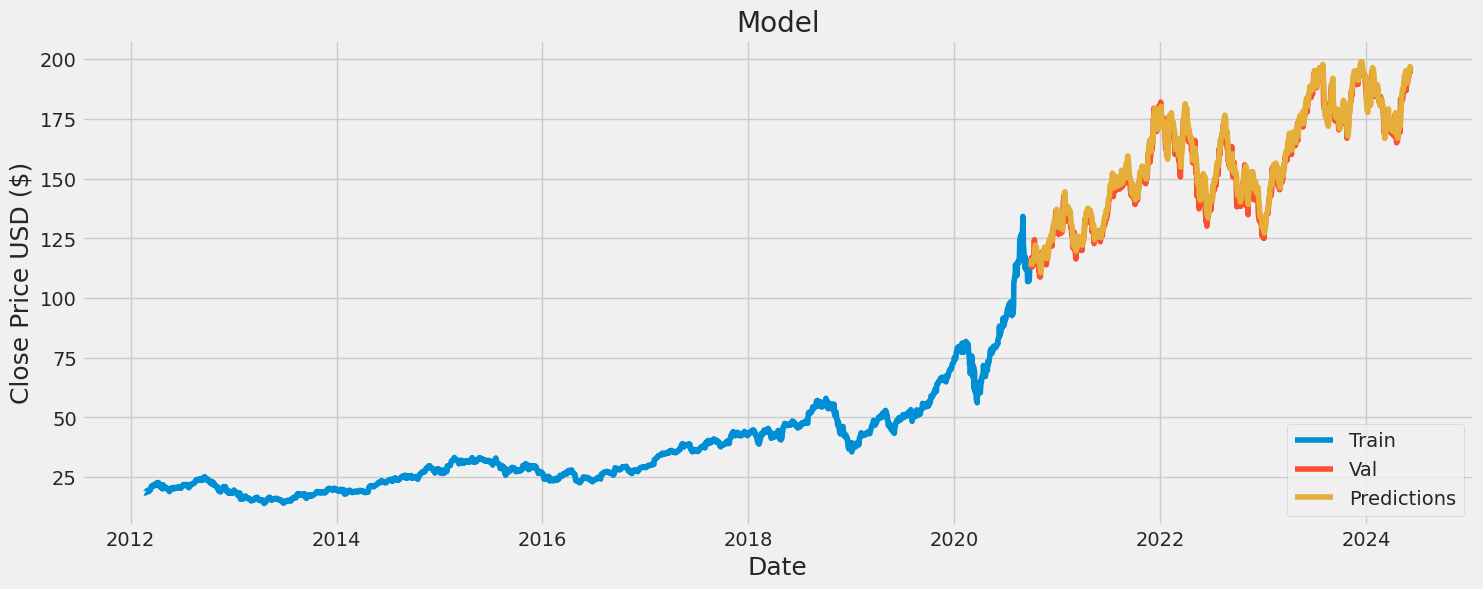

In [20]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

The blue line represents the training data, indicating the historical prices used to train the model.
The red line indicates the validation data, showing the data the model did not see during training but was used to validate its performance.
The orange line represents the predictions made by the model on the validation data.
The results indicate that our LSTM model performs well in capturing the overall trends and patterns in the AAPL stock prices. The close alignment between the predicted values and actual values suggests that the model generalizes well to unseen data.

The visualization of the predictions shows that the model can reasonably predict future stock prices, making it a valuable tool for financial forecasting.

In [21]:
# Displaying Validiation and Predicted Prices for Comparison:
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2020-09-30,115.809998,113.073454
2020-10-01,116.790001,114.373113
2020-10-02,113.019997,115.816724
2020-10-05,116.500000,114.788118
2020-10-06,113.160004,115.576680
...,...,...
2024-06-03,194.029999,193.204219
2024-06-04,194.350006,194.702067
2024-06-05,195.869995,195.610387


# **Future Directions:**
 Future work can include further tuning of the model, experimenting with additional features, and testing on other stocks to validate the robustness of the approach.